In [30]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [38]:
torch.cuda.get_device_name()
torch.cuda.is_available()
torch.cuda.current_device()
device = 'cuda'

In [39]:


transform = transforms.Compose([transforms.ToTensor()])
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


In [40]:

idx = (mnist.targets == 0) | (mnist.targets == 1)
mnist.data = mnist.data[idx]
mnist.targets = mnist.targets[idx]


n_samples = 1000
selected_idx = torch.randperm(len(mnist.data))[:n_samples]
X = mnist.data[selected_idx].float() / 255.0 
X = X.reshape(n_samples, -1)  


T = 100  
timesteps = torch.linspace(0, 2, T)

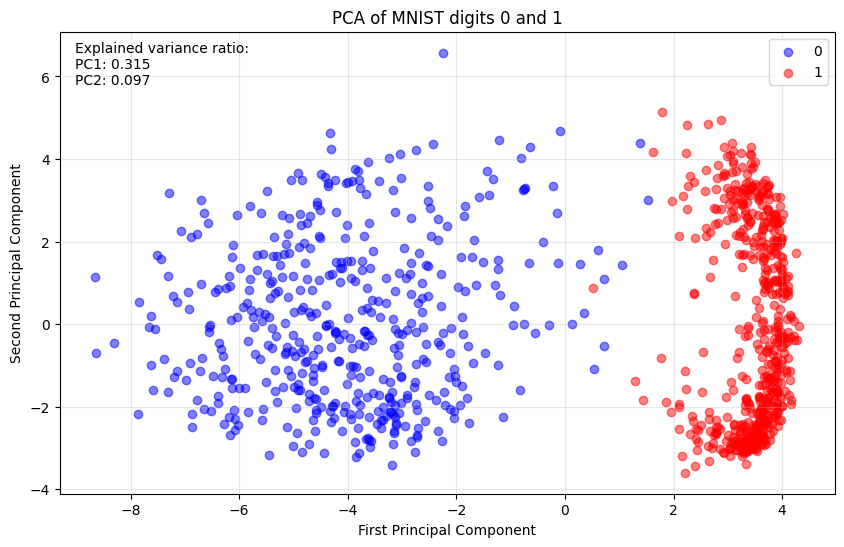

In [41]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)


X_pca = pca.fit_transform(X)


plt.figure(figsize=(10, 6))
plt.scatter(X_pca[mnist.targets[selected_idx]==0, 0], 
           X_pca[mnist.targets[selected_idx]==0, 1],
           alpha=0.5, c='blue', label='0')
plt.scatter(X_pca[mnist.targets[selected_idx]==1, 0],
           X_pca[mnist.targets[selected_idx]==1, 1], 
           alpha=0.5, c='red', label='1')
plt.title('PCA of MNIST digits 0 and 1')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()


explained_var = pca.explained_variance_ratio_
plt.text(0.02, 0.98, f'Explained variance ratio:\nPC1: {explained_var[0]:.3f}\nPC2: {explained_var[1]:.3f}', 
         transform=plt.gca().transAxes, verticalalignment='top')

plt.grid(True, alpha=0.3)
plt.show()


In [42]:

def compute_P_t_e_and_entropy(x, x_0, t, device='cuda'):
    x = x.to(device)
    x_0 = x_0.to(device)
    t = t.to(device)
    if len(t.shape) == 1:
        t = t.repeat(x.shape[0])
    
    Delta_t = 1 - torch.exp(-2*t)
    t = t.view(-1, 1)
    exp_t = torch.exp(-t)  # [B,1]
    x_expanded = x.unsqueeze(1)  # [B,1,D]
    x0_expanded = x_0.unsqueeze(0)  # [1,N,D]
    diff = x_expanded - x0_expanded * exp_t.unsqueeze(-1)  # [B,N,D]
    gaussian = torch.exp(-torch.sum(diff**2, dim=-1)/(2*Delta_t.view(-1,1)))  # [B,N]
    
    P_t_e = gaussian.mean(dim=1) / (torch.sqrt(2*np.pi*Delta_t.squeeze()))**x.shape[-1]
    
    entropy = -torch.mean(torch.log(P_t_e + 1e-10)) 
    return P_t_e.to(device), entropy.to(device)


In [43]:


def plot_entropy_vs_time(x_0, n_points=100, n_samples=1000, device='cuda'):
    import matplotlib.pyplot as plt
    
    times = torch.linspace(0, T-1, n_points)
    entropies = []
    
    for t in times:
        x = torch.randn(n_samples, x_0.shape[1], device=device)
        _, entropy = compute_P_t_e_and_entropy(x, x_0, t*torch.ones(n_samples))
        entropies.append(entropy.cpu().item())
    
    plt.figure(figsize=(10,6))
    plt.plot(times.cpu(), entropies)
    plt.xlabel('Time t')
    plt.ylabel('Entropy s(t)')
    plt.title('Entropy of empirical distribution vs time')
    plt.grid(True)
    plt.show()


In [44]:

pca = PCA(n_components=2)
X_pca = torch.tensor(pca.fit_transform(X.cpu().numpy()), device=device)
x_pca = torch.randn(n_samples, 2, device=device)
P_t_e, entropy = compute_P_t_e_and_entropy(x_pca, X_pca[:20], timesteps)


RuntimeError: The size of tensor a (1000) must match the size of tensor b (100000) at non-singleton dimension 0